In [14]:
import pandas as pd
import numpy as np
import sqlite3
import zipfile
import ast
import seaborn as sns
import matplotlib.pyplot as plt

## List of Dataframes:

In [3]:
# Dataframes
movie_info_df = pd.read_csv('zippedData/rt.movie_info.tsv.gz', sep='\t', compression='gzip')
movie_info_drop = ['box_office', 'currency', 'dvd_date', 'studio']
movie_info_df = movie_info_df.drop(columns=movie_info_drop)
print(f'movie_info_df columns: \n{list(movie_info_df.columns)}\n')


movie_gross_df = pd.read_csv('zippedData/bom.movie_gross.csv.gz')
print(f'movie_gross_df columns: \n{list(movie_gross_df.columns)}\n')

movie_budget_df = pd.read_csv('zippedData/tn.movie_budgets.csv.gz')
print(f'movie_budget_df columns: \n{list(movie_budget_df.columns)}\n')

movie_reviews_df = pd.read_csv('zippedData/rt.reviews.tsv.gz', sep='\t', compression='gzip', encoding='latin-1')
movie_review_drop = ['rating']
movie_reviews_df = movie_reviews_df.drop(columns=movie_review_drop) # Dropping rating: poor formatting & lacking 50% of data.
print(f'movie_reviews_df columns: \n{list(movie_reviews_df.columns)}\n')


tmbd_movie_df = pd.read_csv('zippedData/tmdb.movies.csv.gz')
print(f'tmbd_movie_df columns: \n{list(tmbd_movie_df.columns)}\n')

movie_info_df columns: 
['id', 'synopsis', 'rating', 'genre', 'director', 'writer', 'theater_date', 'runtime']

movie_gross_df columns: 
['title', 'studio', 'domestic_gross', 'foreign_gross', 'year']

movie_budget_df columns: 
['id', 'release_date', 'movie', 'production_budget', 'domestic_gross', 'worldwide_gross']

movie_reviews_df columns: 
['id', 'review', 'fresh', 'critic', 'top_critic', 'publisher', 'date']

tmbd_movie_df columns: 
['Unnamed: 0', 'genre_ids', 'id', 'original_language', 'original_title', 'popularity', 'release_date', 'title', 'vote_average', 'vote_count']



**Combined Datraframe**: MAIN_DF

In [4]:
#change budget column name to title instead of movie
movie_budget_df = movie_budget_df.rename(columns={'movie': 'title'})
# Merge tmbd_movie_df and movie_gross_df]
main_df = pd.merge(tmbd_movie_df, movie_gross_df, on='title', how='left')
# Keep only the 'title' and 'production_budget' columns from movie_budget_df
main_budget_df = movie_budget_df[['title', 'production_budget']]
# Merge master_df and movie_budget_df
main_df = pd.merge(main_df, movie_budget_df, on='title', how='left')
# Drop unused column
column_to_drop = ['Unnamed: 0', 'release_date_y', 'domestic_gross_y', 'id_y', 'year']
main_df = main_df.drop(columns=column_to_drop)
#rename main_df columns to better reflact data
main_df = main_df.rename(columns={'id_x': 'id', 'release_date_x': 'release_date', 'domestic_gross_x': 'domestic_gross'})


Cleaning & filtering **MAIN_DF**:

In [5]:
# Filter to only english
main_df = main_df[main_df['original_language'] == 'en']
# Filter by 2010 and sooner
main_df = main_df[main_df['release_date'] >= '2010-01-01']
#Updateing 'production_budget' & 'worldwide_gross' columns
# First, replace $ and ,
main_df['production_budget'] = main_df['production_budget'].str.replace('$', '').str.replace(',', '')
main_df['worldwide_gross'] = main_df['worldwide_gross'].str.replace('$', '').str.replace(',', '')
# Fill NaNs with 0
main_df['production_budget'] = main_df['production_budget'].fillna(0)
main_df['worldwide_gross'] = main_df['worldwide_gross'].fillna(0)
# Now convert to int
main_df['production_budget'] = main_df['production_budget'].astype(int)
main_df['worldwide_gross'] = main_df['worldwide_gross'].astype(int)
# Adding Columns
main_df['net_profit'] = main_df['worldwide_gross'] - main_df['production_budget']
main_df['roi'] = main_df['net_profit'] / main_df['production_budget'] * 100
# Create a dictionary mapping genre IDs to names, all in lowercase
genre_dict = {28: 'action', 12: 'adventure', 16: 'animation', 35: 'comedy', 80: 'crime', 99: 'documentary', 
              18: 'drama', 10751: 'family', 14: 'fantasy', 36: 'history', 27: 'horror', 10402: 'music', 
              9648: 'mystery', 10749: 'romance', 878: 'science fiction', 10770: 'tv movie', 53: 'thriller', 
              10752: 'war', 37: 'western'}

def decode_genre_ids(genre_ids_string):
    # Convert string to list
    genre_ids = ast.literal_eval(genre_ids_string)
    # Return the genre names corresponding to the IDs
    return [genre_dict[id] for id in genre_ids if id in genre_dict]

# Apply the function to each value in the 'genre_ids' column
main_df['genres'] = main_df['genre_ids'].apply(decode_genre_ids)



In [6]:
main_df.head()

,genre_ids,id,original_language,original_title,popularity,release_date,title,vote_average,vote_count,studio,domestic_gross,foreign_gross,production_budget,worldwide_gross,net_profit,roi,genres
0,"[12, 14, 10751]",12444,en,Harry Potter and the Deathly Hallows: Part 1,33.533,2010-11-19,Harry Potter and the Deathly Hallows: Part 1,7.7,10788,NaN,NaN,NaN,0,0,0,NaN,"[adventure, fantasy, family]"
1,"[14, 12, 16, 10751]",10191,en,How to Train Your Dragon,28.734,2010-03-26,How to Train Your Dragon,7.7,7610,P/DW,217600000.0,277300000,165000000,494870992,329870992,199.921813,"[fantasy, adventure, animation, family]"
2,"[12, 28, 878]",10138,en,Iron Man 2,28.515,2010-05-07,Iron Man 2,6.8,12368,Par.,312400000.0,311500000,170000000,621156389,451156389,265.386111,"[adventure, action, science fiction]"
4,"[28, 878, 12]",27205,en,Inception,27.920,2010-07-16,Inception,8.3,22186,WB,292600000.0,535700000,160000000,835524642,675524642,422.202901,"[action, science fiction, adventure]"
5,"[12, 14, 10751]",32657,en,Percy Jackson & the Olympians: The Lightning T...,26.691,2010-02-11,Percy Jackson & the Olympians: The Lightning T...,6.1,4229,NaN,NaN,NaN,95000000,223050874,128050874,134.790394,"[adventure, fantasy, family]"


In [7]:
main_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23184 entries, 0 to 26605
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   genre_ids          23184 non-null  object 
 1   id                 23184 non-null  int64  
 2   original_language  23184 non-null  object 
 3   original_title     23184 non-null  object 
 4   popularity         23184 non-null  float64
 5   release_date       23184 non-null  object 
 6   title              23184 non-null  object 
 7   vote_average       23184 non-null  float64
 8   vote_count         23184 non-null  int64  
 9   studio             2159 non-null   object 
 10  domestic_gross     2148 non-null   float64
 11  foreign_gross      1498 non-null   object 
 12  production_budget  23184 non-null  int64  
 13  worldwide_gross    23184 non-null  int64  
 14  net_profit         23184 non-null  int64  
 15  roi                2191 non-null   float64
 16  genres             231

In [8]:
main_df.isna().sum().sort_values(ascending=False)


foreign_gross        21686
domestic_gross       21036
studio               21025
roi                  20993
genres                   0
release_date             0
id                       0
original_language        0
original_title           0
popularity               0
vote_count               0
title                    0
vote_average             0
production_budget        0
worldwide_gross          0
net_profit               0
genre_ids                0
dtype: int64

### movie_info_df: cleaned

In [ ]:
movie_info_df.info()

In [ ]:
movie_info_df.isna().sum().sort_values(ascending=False)

Cleaning & Filtering for **MOVIE_INFO_DF**:

In [9]:
# Dropping 8 null rows with missing genre. Most info is missing with them:
movie_info_df = movie_info_df.dropna(subset=['genre'])

# filling all empty values with 'unknown' for ['synopsis', 'runtime', 'director', 'theater_date', 'writer']:
columns_to_fill = ['synopsis', 'runtime', 'director', 'theater_date', 'writer']
movie_info_df[columns_to_fill] = movie_info_df[columns_to_fill].fillna('unknown')

# Filtering date to 2010 and forward
movie_info_df['theater_date'] = pd.to_datetime(movie_info_df['theater_date'], format='%b %d, %Y', errors='coerce')
movie_info_df = movie_info_df[movie_info_df['theater_date'] >= 'Jan 1, 2010']



# changing runtime to int + removing 'minutes' + changing name of the column to reflect:
movie_info_df.loc[movie_info_df['runtime'] != 'unknown', 'runtime'] = movie_info_df.loc[movie_info_df['runtime'] != 'unknown', 'runtime'].str.replace(' minutes', '').astype(int)
movie_info_df = movie_info_df.rename(columns={'runtime': 'runtime_in_minutes'})

# drop all 26 unknown runtimes:
movie_info_df = movie_info_df[movie_info_df['runtime_in_minutes'] != 'unknown']


In [ ]:
movie_info_df.head(3)

**MOVIE_INFO_DF** Analysis:

In [ ]:
# 81% of the movie market is rated PG-13, R and NR:
movie_info_df['rating'].value_counts()

In [ ]:
# average movie length is just over 100 minutes
movie_info_df['runtime_in_minutes'].mean()

In [ ]:
# Top Directors
movie_info_df['director'].value_counts().head(20)

In [ ]:
# Top Writers
movie_info_df['writer'].value_counts().head(20)

In [ ]:
# Top Genres seem to be a mix of Drama & Comedy
movie_info_df['genre'].value_counts().head(20)

### movie_reviews_df: cleaned

In [ ]:
movie_reviews_df.info()

In [ ]:
movie_reviews_df.isna().sum().sort_values(ascending=False)

**MOVIE_REVIEWS_DF** Data cleaning:

In [ ]:
# Filtering to only top_critics == 1
movie_reviews_df = movie_reviews_df[movie_reviews_df['top_critic'] == 1]
# filling null 'publisher', 'critic', 'review' values with 'Unknown':
fill_columns = ['publisher', 'critic', 'review']
movie_reviews_df[fill_columns] = movie_reviews_df[fill_columns].fillna('unknown')
# Filtering date to 2010 and forward
movie_reviews_df['date'] = pd.to_datetime(movie_reviews_df['date'])
movie_reviews_df = movie_reviews_df[movie_reviews_df['date'] >= '2010-01-01']





In [ ]:
movie_reviews_df.head(20)

**MOVIE_REVIEW_DF** Analysis:

Top_Critics reviews = 4,713

In [ ]:
movie_reviews_df['top_critic'].sum()

Names of the top 20 critics:

In [ ]:
movie_reviews_df['critic'].value_counts().head(20)

Fresh vs. Rotten; 

- fresh = 60%
- Rotten = 40%

In [ ]:
movie_reviews_df['fresh'].value_counts()

---

# SQL DATABASE

* Unzipping the '**im.db.zip**' file 
* Connecting to database using '**conn**'
* Printing all of the **table names** within the database


**Important note**: movie_basics & movie_ratings are the most relevant per instructions

In [22]:
# Unzip the database file
with zipfile.ZipFile('zippedData/im.db.zip', 'r') as zip_ref:
    zip_ref.extractall('zippedData')

# Connect to the unzipped SQLite database
conn = sqlite3.connect('zippedData/im.db')

# Run test query
q = """
SELECT tbl_name AS table_name, sql
FROM sqlite_master 
WHERE type='table'
ORDER BY name;
"""
pd.read_sql(q, conn)

,table_name,sql
0,directors,"CREATE TABLE ""directors"" (\n""movie_id"" TEXT,\n..."
1,known_for,"CREATE TABLE ""known_for"" (\n""person_id"" TEXT,\..."
2,movie_akas,"CREATE TABLE ""movie_akas"" (\n""movie_id"" TEXT,\..."
3,movie_basics,"CREATE TABLE ""movie_basics"" (\n""movie_id"" TEXT..."
4,movie_ratings,"CREATE TABLE ""movie_ratings"" (\n""movie_id"" TEX..."
5,persons,"CREATE TABLE ""persons"" (\n""person_id"" TEXT,\n ..."
6,principals,"CREATE TABLE ""principals"" (\n""movie_id"" TEXT,\..."
7,writers,"CREATE TABLE ""writers"" (\n""movie_id"" TEXT,\n ..."


In [24]:
# Movie Basics
q = '''
SELECT *
FROM movie_basics
WHERE original_title LIKE "Toy%"
LIMIT 3
;
'''
pd.read_sql(q, conn)

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres
0,tt0435761,Toy Story 3,Toy Story 3,2010,103.0,"Adventure,Animation,Comedy"
1,tt1608255,Toyland,Toyland,2010,68.0,"Biography,Documentary,Family"
2,tt1754780,Toy Masters,Toy Masters,2012,97.0,"Biography,Comedy,Documentary"


In [25]:
# Moving Ratings
q = '''
SELECT *
FROM movie_ratings
LIMIT 3
;
'''
pd.read_sql(q, conn)

,movie_id,averagerating,numvotes
0,tt10356526,8.3,31
1,tt10384606,8.9,559
2,tt1042974,6.4,20


In [26]:
# Directors
q = '''
SELECT *
FROM directors
LIMIT 3
;
'''
pd.read_sql(q, conn)

,movie_id,person_id
0,tt0285252,nm0899854
1,tt0462036,nm1940585
2,tt0835418,nm0151540


In [27]:
# Known For
q = '''
SELECT *
FROM known_for
LIMIT 3
;
'''
pd.read_sql(q, conn)

,person_id,movie_id
0,nm0061671,tt0837562
1,nm0061671,tt2398241
2,nm0061671,tt0844471


In [28]:
# Movie AKAs
q = '''
SELECT *
FROM movie_akas
LIMIT 3
;
'''
pd.read_sql(q, conn)

,movie_id,ordering,title,region,language,types,attributes,is_original_title
0,tt0369610,10,Джурасик свят,BG,bg,None,None,0.0
1,tt0369610,11,Jurashikku warudo,JP,None,imdbDisplay,None,0.0
2,tt0369610,12,Jurassic World: O Mundo dos Dinossauros,BR,None,imdbDisplay,None,0.0


In [29]:
# Persons
q = '''
SELECT *
FROM persons
LIMIT 3
;
'''
pd.read_sql(q, conn)

,person_id,primary_name,birth_year,death_year,primary_profession
0,nm0061671,Mary Ellen Bauder,None,None,"miscellaneous,production_manager,producer"
1,nm0061865,Joseph Bauer,None,None,"composer,music_department,sound_department"
2,nm0062070,Bruce Baum,None,None,"miscellaneous,actor,writer"


In [30]:
# Pricipals
q = '''
SELECT *
FROM principals
LIMIT 3
;
'''
pd.read_sql(q, conn)

,movie_id,ordering,person_id,category,job,characters
0,tt0111414,1,nm0246005,actor,None,"[""The Man""]"
1,tt0111414,2,nm0398271,director,None,None
2,tt0111414,3,nm3739909,producer,producer,None


In [31]:
# Writers
q = '''
SELECT *
FROM writers
LIMIT 3
;
'''
pd.read_sql(q, conn)

,movie_id,person_id
0,tt0285252,nm0899854
1,tt0438973,nm0175726
2,tt0438973,nm1802864


---

In [23]:
# joined file
q = '''
SELECT *
FROM movie_basics mb
JOIN directors dr USING(movie_id)
JOIN principals pr USING(movie_id)
JOIN persons p USING(person_id)
JOIN movie_ratings mr USING(movie_id)
WHERE death_year IS NULL
GROUP BY movie_id
ORDER BY start_year
;
'''
pd.read_sql(q, conn)

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres,person_id,ordering,person_id,category,job,characters,primary_name,birth_year,death_year,primary_profession,averagerating,numvotes
0,tt0146592,Pál Adrienn,Pál Adrienn,2010,136.0,Drama,nm1030585,1,nm3140529,actress,None,"[""Piroska""]",Ágnes Kocsis,1971.0,None,"director,writer,producer",6.8,451
1,tt0162942,Children of the Green Dragon,A zöld sárkány gyermekei,2010,89.0,Drama,nm1207262,1,nm0753588,actor,None,"[""Máté János""]",Bence Miklauzic,1970.0,None,"director,writer,assistant_director",6.9,120
2,tt0312305,Quantum Quest: A Cassini Space Odyssey,Quantum Quest: A Cassini Space Odyssey,2010,45.0,"Adventure,Animation,Sci-Fi",nm0820800,1,nm1517976,actor,None,"[""Dave""]",Daniel St. Pierre,1961.0,None,"animation_department,art_department,director",5.1,287
3,tt0326592,The Overnight,The Overnight,2010,88.0,None,nm1208371,1,nm1211335,actor,None,"[""Ted Bell""]",Jed I. Goodman,NaN,None,"camera_department,writer,producer",7.5,24
4,tt0326965,In My Sleep,In My Sleep,2010,104.0,"Drama,Mystery,Thriller",nm1075006,1,nm0934618,actor,None,"[""Marcus""]",Allen Wolf,1970.0,None,"miscellaneous,producer,director",5.5,1889
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72532,tt9913056,Swarm Season,Swarm Season,2019,86.0,Documentary,nm1502645,1,nm1502645,director,None,None,Sarah Christman,NaN,None,"miscellaneous,director,editor",6.2,5
72533,tt9913084,Diabolik sono io,Diabolik sono io,2019,75.0,Documentary,nm0812850,1,nm0769233,actor,None,"[""Zarcone""]",Giancarlo Soldi,1954.0,None,"director,writer,producer",6.2,6
72534,tt9914286,Sokagin Çocuklari,Sokagin Çocuklari,2019,98.0,"Drama,Family",nm4394529,1,nm4394529,actor,None,None,Ahmet Faik Akinci,NaN,None,"director,writer",8.7,136
72535,tt9914942,La vida sense la Sara Amat,La vida sense la Sara Amat,2019,NaN,None,nm1716653,1,nm1290838,actor,None,None,Laura Jou,NaN,None,"miscellaneous,actress,director",6.6,5


---

# **Recommendations**

### Worldwide vs Domestic vs Foreign:

* based on the data from our dataframes, we have decided recommend launching your movie **Worldwide**. 
* We ran into a lot of data limitations when breaking down domestic vs foreign but we had plenty to work with as it pertained to **production budget** & **worldwide**.
* **We recommend launching the movie worldwide**

Further Filtering:

In [10]:
calc_df = main_df

# Filtering columns
calc_df = calc_df[calc_df['production_budget'] > 0]
calc_df = calc_df[calc_df['worldwide_gross'] > 0]
calc_df = calc_df[calc_df['roi'] > 0]
calc_df = calc_df[calc_df['domestic_gross'] > 0]
calc_df = calc_df[~calc_df['foreign_gross'].isna()]
# Sorting values by ROI
calc_df = calc_df.sort_values('roi', ascending=False)
# removing movie duplicates values in ROI
calc_df = calc_df.loc[~calc_df['roi'].duplicated(), :]

**Visualization comparing movie location**:

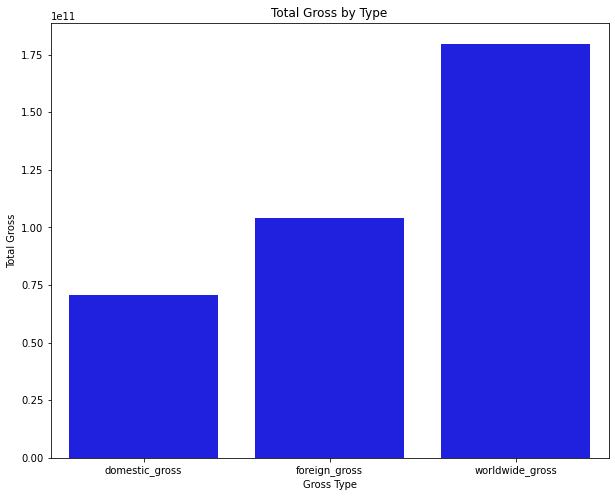

In [37]:
# convert 'foreign_gross' to float
calc_df['foreign_gross'] = pd.to_numeric(calc_df['foreign_gross'], errors='coerce')

# calculate the sums
sums = calc_df[['domestic_gross', 'foreign_gross', 'worldwide_gross']].sum()

# create a new dataframe with sums
df_sums = pd.DataFrame({'gross_type': sums.index, 'sum': sums.values})

# Now use seaborn to create the visualization
plt.figure(figsize=(10,8))
sns.barplot(x='gross_type', y='sum', data=df_sums, ci=None, color='blue')
plt.title('Total Gross by Type')
plt.xlabel('Gross Type')
plt.ylabel('Total Gross')
# plt.xticks(rotation=90) # This line is commented out to display labels horizontally
plt.show();

Based on **top 10 movies (ROI)**

* The best ROI ranges from **41,560% to 3,852%** increse
* **70%** of the top ROI movies are a mix of **Horror** and **Thriller**
* **We recommend making a HORROR/THRILLER MOVIE**

In [11]:
calc_df[['title', 'roi', 'genres']].head(10)

,title,roi,genres
14420,The Gallows,41556.474000,"[horror, thriller]"
5468,The Devil Inside,10075.949000,"[thriller, horror]"
2512,Insidious,6558.059067,"[horror, thriller]"
14490,Unfriended,6336.419800,"[horror, thriller]"
235,Paranormal Activity 2,5817.067733,"[horror, thriller]"
17455,Split,5479.296120,"[horror, thriller]"
1541,Get Out,5007.359020,"[comedy, animation]"
5253,Chernobyl Diaries,4141.172100,"[horror, thriller]"
2663,Paranormal Activity 3,4040.796880,[horror]
11133,Annabelle,3851.737231,[horror]


**Visualization comparing genre return on investment (ROI)**

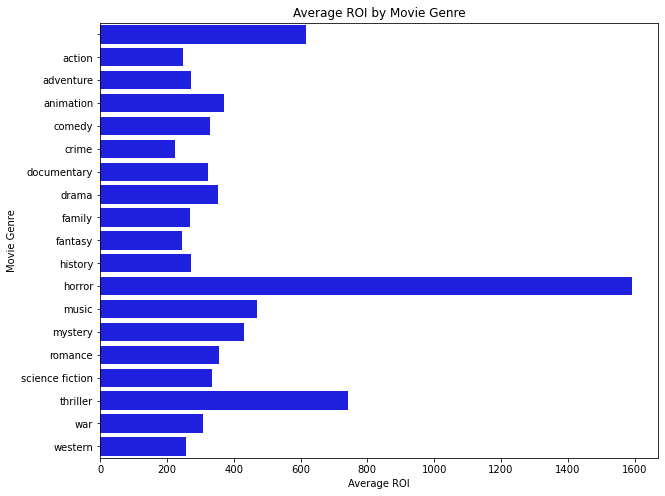

In [29]:
# assuming your dataframe is calc_df
calc_df['genres'] = calc_df['genres'].apply(lambda x: ', '.join(x)) # Joining genres into string if they are list
calc_df['genres'] = calc_df['genres'].apply(lambda x: x.split(', ')) # Splitting genres to make them list again
calc_df_exploded = calc_df.explode('genres') # This will create separate rows for each genre

# Now you can use groupby to find the mean 'roi' for each genre
genre_group = calc_df_exploded.groupby('genres')['roi'].mean().reset_index()

# Now use seaborn to create the visualization
plt.figure(figsize=(10,8))
sns.barplot(x='roi', y='genres', data=genre_group, ci=None, color='blue')
plt.title('Average ROI by Movie Genre')
plt.xlabel('Average ROI')
plt.ylabel('Movie Genre')
plt.show()

Here are the individual genre counts across all movies for visability:

In [12]:
genre_counts = calc_df['genres'].explode().value_counts()
genre_counts

drama              342
comedy             315
action             256
thriller           220
adventure          198
family             130
science fiction    122
crime              104
romance            104
fantasy            104
horror              94
animation           82
mystery             63
history             36
music               18
war                 17
documentary         11
western              7
Name: genres, dtype: int64

**Movie length (minutes)**

* We found that the average movie length was just over **106 mintues**.
* **We recommend keeping the movie length between 100-110 minutes**

In [13]:
# average movie length is just over 100 minutes
movie_info_df['runtime_in_minutes'].mean()

106.5228426395939

**Best DIRECTORS for the Horror/Thriller Genre**

* Based on the most profitable movies: 
* **We recommend hiring any of the below Directors in no particular order**
1. Deborah Kampmeier
2. Alexander Wraith	
3. Ariel Schulman
4. Joaquin Perea
5. John R. Leonetti	
6. Bradley Parker
7. Chris Lofing	
8. Christopher Landon
9. Gregory Plotkin
10. William Brent Bell

In [41]:
# Enter SQL Code here
q = """
SELECT *
FROM movie_basics mb
JOIN directors dr USING(movie_id)
JOIN principals pr USING(movie_id)
JOIN persons p USING(person_id)
JOIN movie_ratings mr USING(movie_id)
WHERE death_year IS NULL
AND
(
original_title LIKE '%Gallows' 
OR original_title LIKE '%Devil Inside' 
OR original_title = 'Insidious' 
OR original_title = 'Unfriended' 
OR original_title LIKE 'Paranormal Activity%' 
OR original_title = 'Split' 
OR original_title = 'Chernobyl Diaries' 
OR original_title = 'Annabelle'
)
AND 
category = 'director'
GROUP BY primary_name
;
"""
pd.read_sql(q, conn)

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres,person_id,ordering,person_id,category,job,characters,primary_name,birth_year,death_year,primary_profession,averagerating,numvotes
0,tt3108988,Paranormal Activity Security Squad,Paranormal Activity Security Squad,2016,NaN,"Comedy,Horror",nm2066764,5,nm2066764,director,None,None,Alexander Wraith,1979.0,None,"actor,writer,producer",5.4,13
1,tt2109184,Paranormal Activity 4,Paranormal Activity 4,2012,88.0,"Horror,Mystery,Thriller",nm1413364,5,nm1160962,director,None,None,Ariel Schulman,NaN,None,"writer,producer,director",4.6,58408
2,tt1991245,Chernobyl Diaries,Chernobyl Diaries,2012,86.0,"Horror,Mystery,Thriller",nm0662086,5,nm0662086,director,None,None,Bradley Parker,NaN,None,"visual_effects,director,art_department",5.0,60304
3,tt2309260,The Gallows,The Gallows,2015,81.0,"Horror,Mystery,Thriller",nm3951039,5,nm4000389,director,None,None,Chris Lofing,NaN,None,"producer,director,writer",4.2,17763
4,tt2473682,Paranormal Activity: The Marked Ones,Paranormal Activity: The Marked Ones,2014,84.0,"Horror,Mystery,Thriller",nm0484907,5,nm0484907,director,None,None,Christopher Landon,1975.0,None,"writer,producer,director",5.0,37147
5,tt3315656,Split,Split,2016,127.0,"Drama,Fantasy",nm1380487,5,nm1380487,director,None,None,Deborah Kampmeier,1964.0,None,"writer,director,producer",3.6,380
6,tt2473510,Paranormal Activity: The Ghost Dimension,Paranormal Activity: The Ghost Dimension,2015,88.0,"Horror,Mystery,Thriller",nm0687427,5,nm0687427,director,None,None,Gregory Plotkin,NaN,None,"editorial_department,editor,producer",4.6,22361
7,tt2109184,Paranormal Activity 4,Paranormal Activity 4,2012,88.0,"Horror,Mystery,Thriller",nm1160962,5,nm1160962,director,None,None,Henry Joost,NaN,None,"writer,producer,director",4.6,58408
8,tt1591095,Insidious,Insidious,2010,103.0,"Horror,Mystery,Thriller",nm1490123,5,nm1490123,director,None,None,James Wan,1977.0,None,"producer,writer,director",6.9,254197
9,tt2660118,Split,Split,2016,90.0,"Comedy,Romance,Sport",nm1406121,5,nm1406121,director,None,None,Jamie Buckner,1980.0,None,"miscellaneous,production_manager,producer",2.9,557


**Best WRITERS for the Horror/Thriller Genre**

 * **We recommend choosing from any of these 15 writers**:


In [46]:
# Enter SQL Code here
alive_writers = """
    SELECT 
        w.*, 
        p.primary_name, 
        ma.title,
        mb.genres,
        ma.language,
        mr.averagerating,
        mr.numvotes
    FROM writers w
    JOIN persons p ON w.person_id = p.person_id
    JOIN movie_basics mb  ON w.movie_id = mb.movie_id
    JOIN movie_akas ma ON w.movie_id = ma.movie_id
    JOIN movie_ratings mr ON w.movie_id = mr.movie_id
    WHERE p.death_year IS NULL
    AND p.primary_profession = 'writer'
    AND (mb.genres LIKE '%Horror%' OR mb.genres LIKE '%Thriller%')
    AND ma.language = 'en'
    AND mr.averagerating >= 7.5
    AND mr.numvotes > 9665
    GROUP BY primary_name
    ORDER BY mr.averagerating DESC
"""
result = pd.read_sql(alive_writers, conn)
result

,movie_id,person_id,primary_name,title,genres,language,averagerating,numvotes
0,tt5354160,nm7861818,Adnan Adib Khan,Mirror Game,"Crime,Mystery,Thriller",en,9.3,18470
1,tt8108198,nm4914249,Arijit Biswas,The Blind Melody,"Crime,Thriller",en,8.5,43409
2,tt4987556,nm5394336,A.N. Balakrishnan,The Only One,"Action,Crime,Thriller",en,8.5,13747
3,tt4016934,nm1941029,Seo-kyeong Jeong,The Handmaiden,"Drama,Romance,Thriller",en,8.1,79272
4,tt4016934,nm1258797,Sarah Waters,The Handmaiden,"Drama,Romance,Thriller",en,8.1,79272
5,tt1821480,nm4449370,Nikhil Vyas,Story,"Mystery,Thriller",en,8.1,51830
6,tt1821480,nm4298729,Advaita Kala,Story,"Mystery,Thriller",en,8.1,51830
7,tt6485666,nm8024751,Ramanagirivasan,Zapped,"Action,Thriller",en,8.0,21988
8,tt1535109,nm5643170,Stephan Talty,A Captain's Story,"Biography,Drama,Thriller",en,7.8,387402
9,tt1535109,nm3697679,Richard Phillips,A Captain's Story,"Biography,Drama,Thriller",en,7.8,387402


**Best ACTORS for the Horror/Thriller Genre**

* **Below are the top 20 actors we recommend pulling from for the horror/thriller movie**:


In [44]:
# Enter SQL Code here
q = """
SELECT principals.movie_id, principals.person_id, principals.category, principals.characters, 
    persons.primary_name, persons.birth_year, persons.death_year, movie_basics.primary_title, 
    movie_basics.genres, movie_ratings.averagerating, movie_ratings.numvotes
FROM principals
JOIN persons USING(person_id)
JOIN movie_basics USING(movie_id)
JOIN movie_ratings USING(movie_id)
WHERE principals.category LIKE '%act%' 
    AND persons.birth_year >= 1968
    AND persons.death_year IS NULL
GROUP BY primary_name
ORDER BY movie_ratings.numvotes DESC

LIMIT 20
;
"""
pd.read_sql(q, conn)

,movie_id,person_id,category,characters,primary_name,birth_year,death_year,primary_title,genres,averagerating,numvotes
0,tt0816692,nm3237775,actress,"[""Murph (10 Yrs.)""]",Mackenzie Foy,2000.0,None,Interstellar,"Adventure,Drama,Sci-Fi",8.6,1299334
1,tt0848228,nm0424060,actress,"[""Natasha Romanoff"",""Black Widow""]",Scarlett Johansson,1984.0,None,The Avengers,"Action,Adventure,Sci-Fi",8.1,1183655
2,tt0993846,nm0000138,actor,"[""Jordan Belfort""]",Leonardo DiCaprio,1974.0,None,The Wolf of Wall Street,"Biography,Crime,Drama",8.2,1035358
3,tt0993846,nm1706767,actor,"[""Donnie Azoff""]",Jonah Hill,1983.0,None,The Wolf of Wall Street,"Biography,Crime,Drama",8.2,1035358
4,tt1130884,nm0607865,actress,"[""Rachel 1""]",Emily Mortimer,1971.0,None,Shutter Island,"Mystery,Thriller",8.1,1005960
5,tt1431045,nm1072555,actress,"[""Vanessa""]",Morena Baccarin,1979.0,None,Deadpool,"Action,Adventure,Comedy",8.0,820847
6,tt1431045,nm4534098,actor,"[""Ajax""]",Ed Skrein,1983.0,None,Deadpool,"Action,Adventure,Comedy",8.0,820847
7,tt2488496,nm5397459,actress,"[""Rey""]",Daisy Ridley,1992.0,None,Star Wars: Episode VII - The Force Awakens,"Action,Adventure,Fantasy",8.0,784780
8,tt1392190,nm2368789,actress,"[""Toast the Knowing""]",Zoë Kravitz,1988.0,None,Mad Max: Fury Road,"Action,Adventure,Sci-Fi",8.1,780910
9,tt0903624,nm0035514,actor,"[""Thorin""]",Richard Armitage,1971.0,None,The Hobbit: An Unexpected Journey,"Adventure,Family,Fantasy",7.9,719629
